In [1]:
from numpy import random
import numpy as np
import sympy
import scipy
from tteVAMP.problem import *
from tteVAMP.utils import *
from tteVAMP.vamp import *

In [11]:
# Euler -Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

#function for simultaing genotype matrix and Weibull distributed phenotypes

# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

def mathematica_evd(n, loc, scale):
    wi = np.random.gumbel(loc=loc, scale=scale, size=[n, 1])
    return wi

# Simulate the outcomes Y
def sim_pheno_Weibull(X, beta, mu, h2, censoring):
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    varwi = np.pi * np.pi / 6
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    
    wi = -mathematica_evd(n=n, loc=-0, scale=1.0)
    # wi = -np.random.gumbel(loc=0, scale=1.0, size=[n, 1])

    y = np.exp(mu + g + c * (wi + emc) )
    mask = np.zeros(n)

    if censoring > 0:
        n = len(y)
        censor_len = int(censoring * n)
        
        # Generate random factors between 0 and 1
        random_factors = np.random.uniform(0, 1, censor_len)
        
        # Apply censoring to the last censor_len positions
        y[-censor_len:, 0] = y[-censor_len:, 0] * random_factors
        
        # Create mask vector
        mask[-censor_len:] = 1


    # An equivalent formulation would be: 
    # y = np.exp(-mathematica_evd(n=n, loc = -(mu+g+c*emc), scale=c))
    alpha = 1.0 / c
    return y, alpha, mask

def sim_pheno_ExpGamma(X, beta, mu, h2, kappa):
    # logY_i = mu + xi beta + sigma * wi, wi = standard Normal variable
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    sigmaE = np.sqrt( (1/h2-1) * sigmaG )
    theta = sigmaE / scipy.special.polygamma(1, kappa)
    # mu tilde
    mut = mu + g - theta * scipy.special.polygamma(0, kappa)
    y = random.gamma(shape=kappa, scale=theta, size=[n,1]) + mut
    return y, kappa, theta, mut

def sim_pheno_LogNormal(X, beta, mu, h2):
    # logY_i = mu + xi beta + sigma * wi, wi = standard Normal variable
    # beta is mx1 vector 
    # mu is nx1 vector 
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)
    sigma = np.sqrt( (1/h2-1) * sigmaG )
    w = random.normal(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp(mu + g + sigma * w)
    return y, sigma
    
def sim_model(problem,h2,p, kappa=None, censoring=0):
    X = sim_geno(problem.n, problem.m, p)
    beta = sim_beta(problem.m, problem.prior_instance.la, problem.prior_instance.sigmas)
    mu = np.zeros((problem.n,1))
    print(problem.model)
    if problem.model == 'Weibull':
        y, alpha, mask = sim_pheno_Weibull(X, beta, mu, h2, censoring)
        return X, beta, y, alpha
    elif problem.model == 'Gamma':
        return X, beta, sim_pheno_ExpGamma(X, beta, mu, h2, kappa)
    elif problem.model == 'LogNormal':
        return X, beta, sim_pheno_LogNormal(X, beta, mu, h2)
    else:
        raise Exception(problem.model, " is not a valid model. Allowed models are: 'Weibull', 'Gamma' and 'LogNormal'")
    

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.3722202522924425
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.5290047533799667
l2 error for z1_hat =  0.9605651047308081
v1 =  0.050136652118083234
true tau2 =  6.2399873309118306
tau2 = 1.8945488136000233
->LMMSE
corr(x2_hat, beta_true) =  [[0.54551192]]
l2 error for x2_hat =  0.8830819063357338
alpha2 =  0.7797244427604418
true gam1 =  2.067070090222987
gam1 =  0.7126331208701373
corr(z2_hat, beta_true) =  [[0.47829486]]
l2 error for z2_hat =  0.8849382488807049
true tau1 =  6.579256495199623
tau1 =  6.706263901810013


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.07063615]
corr(x1_hat, beta_true) =  0.5775663621290885
l2 error for x1_hat =  0.89362017392

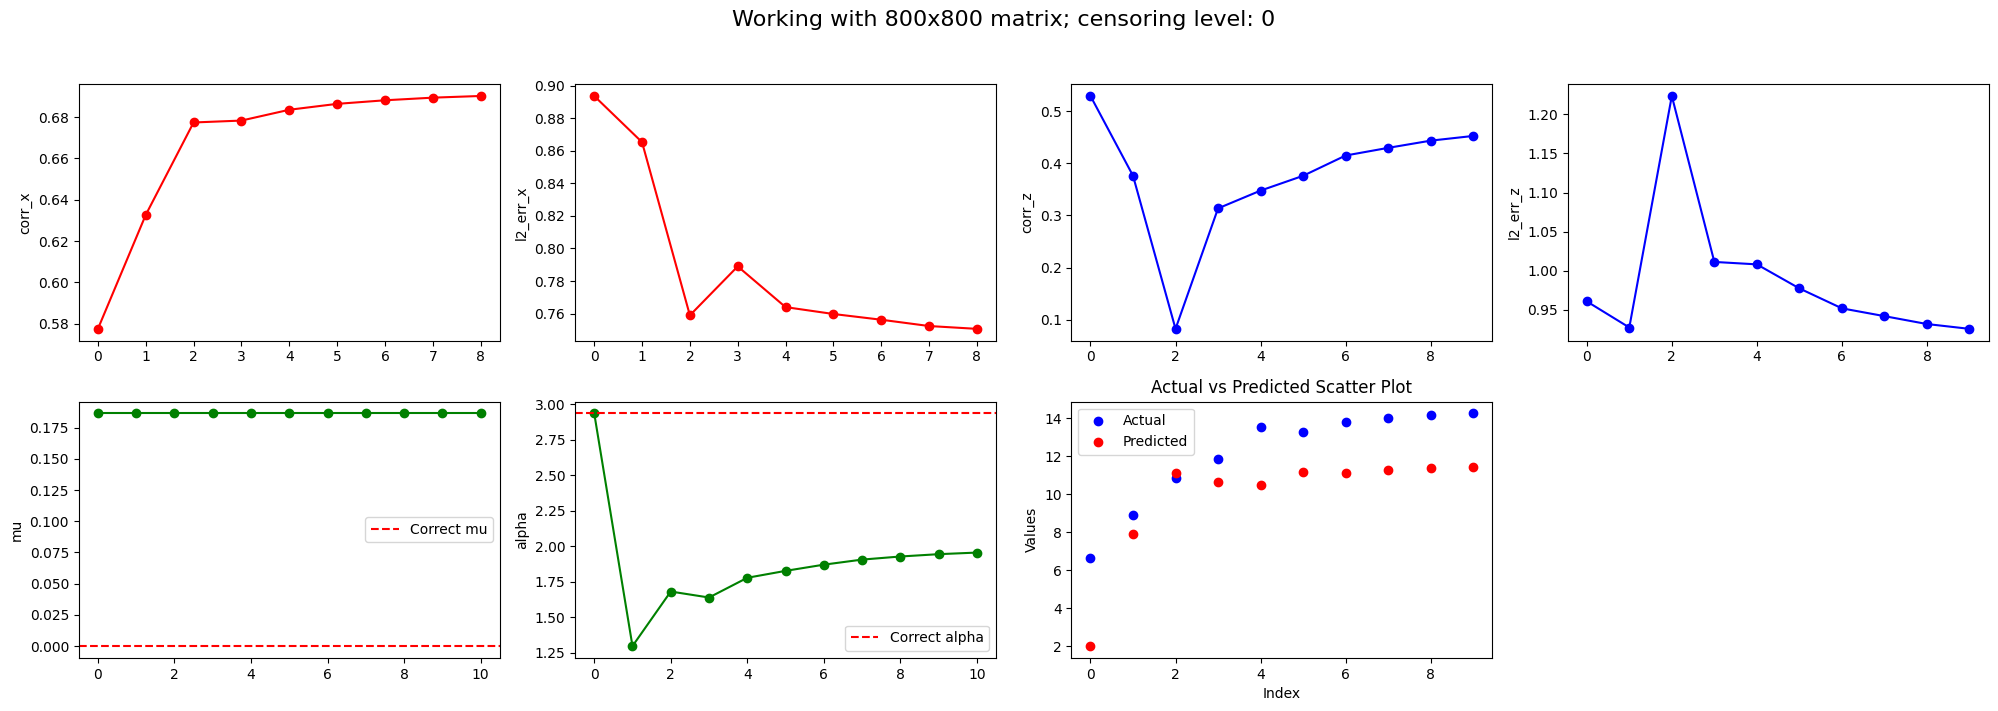

In [6]:
np.random.seed(42)
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 10
censoring = 0

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p,censoring=censoring)
problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m, f"Working with {n}x{m} matrix; censoring level: {censoring}")

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.9361235628007685
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.3722202522924425
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.49998073830069645
l2 error for z1_hat =  1.1739980586224952
v1 =  0.13001463543431535
true tau2 =  2.6266383017406953
tau2 = 0.6691441787760961
->LMMSE
corr(x2_hat, beta_true) =  [[0.39913851]]
l2 error for x2_hat =  0.9467873859143224
alpha2 =  0.8964857888053603
true gam1 =  1.0742751534303105
gam1 =  0.2912711099331265
corr(z2_hat, beta_true) =  [[0.55008586]]
l2 error for z2_hat =  0.8364153285174755
true tau1 =  5.790774527418882
tau1 =  5.795129383796796


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.16600973]
corr(x1_hat, beta_true) =  0.40775707903024405
l2 error for x1_hat =  0.951372768

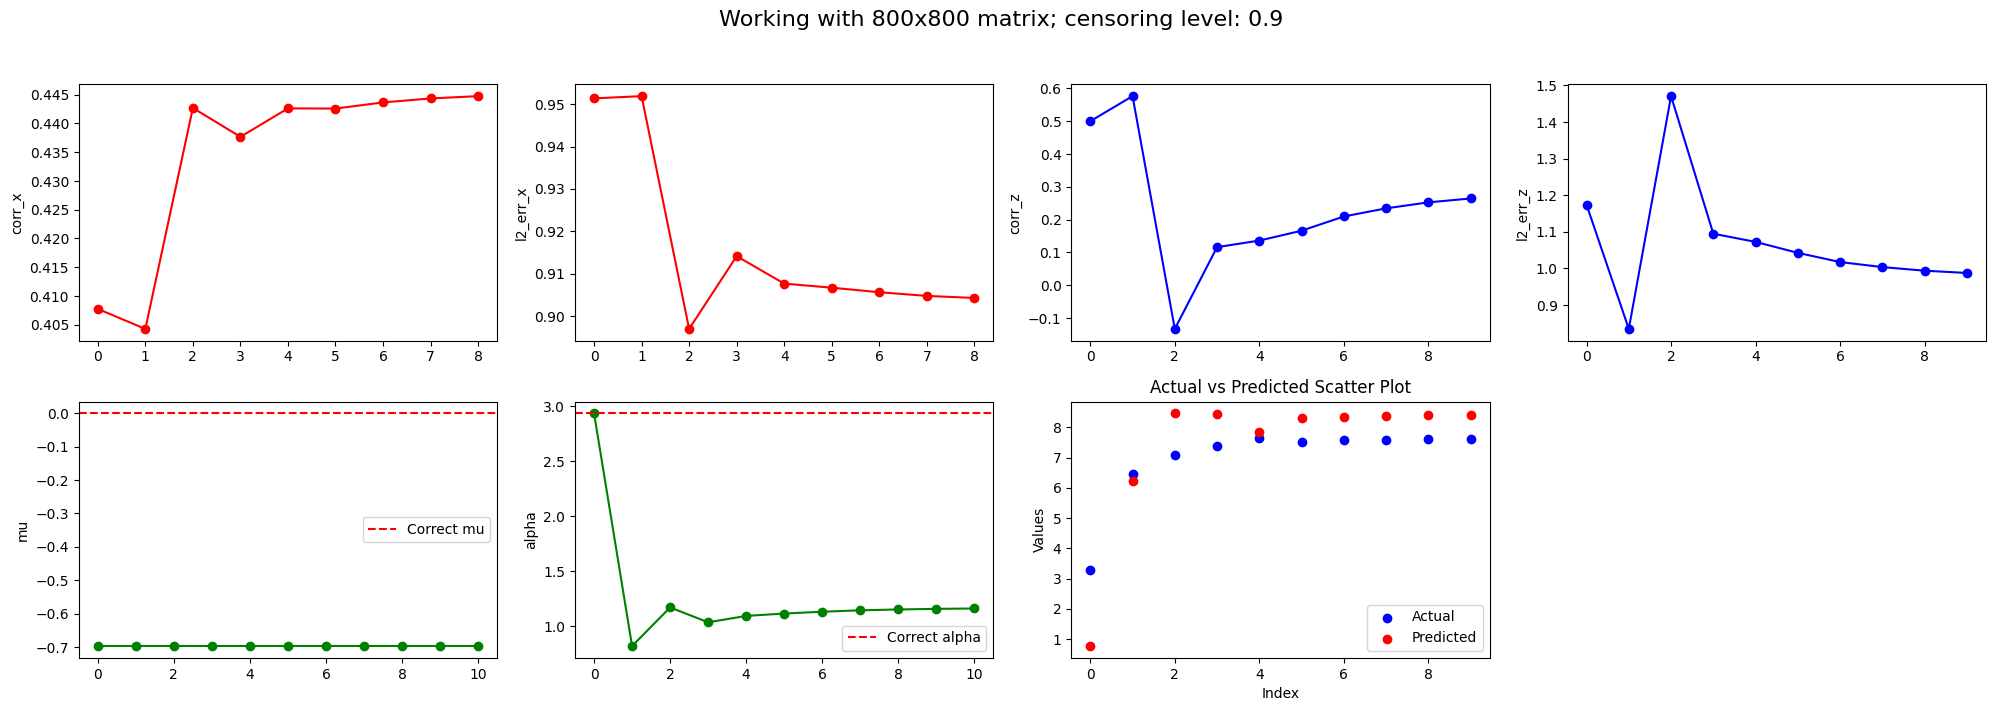

In [12]:
np.random.seed(42)
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1
mu=np.full((n,1), 0) 
maxiter = 10
censoring = 0.9

problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p,censoring=censoring)
problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats =  infere(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m, f"Working with {n}x{m} matrix; censoring level: {censoring}")

Censored LMMSE update

In [ ]:
import time
import numpy as np
from scipy.stats import norm
from tteVAMP.denoisers import *
from tteVAMP.em import *

# prior, y, alpha, mu, maxiter, beta_true
def infere(X, y, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            # Note that this is not exactly a correlation
            # Instead this is an alignment score
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            # corr = np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta_true, axis=-1))
            # print("corr(x1_hat, beta_true) = ", corr[0, 1])
            # corrs_x.append(corr[0, 1])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # Just as above, this is an alignment score, not correlation
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        # corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        # print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        # corrs_z.append(corr[0, 1])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        # mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        # problem.prior_instance.distribution_parameters['alpha'] = alpha
        # problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

        
        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats